# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The purpose of this project is to find lane lines on the road from still images and video streams.

First, I addressed a lane detection on a sample of still image step by step.

Second, a lane detection on a collection of images is tested and outputs is saved as part of this exercise.

Thrid, a lane detection on video streams is tested. Straight lanes are detected and localised reasonably, but there are some issues associated with curved lanes that are not addressed correctly. This curved lane detection is addressed as part of the second project.

---

## Set up packages to use

Prior to this problem solving, I will import all required packages for a lane detection for both still images and video streams.

In [1]:
#import libraries to be used and set up for a plot inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
#the following package is for unpacking and packing video streams
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Helper functions step by step

The lane detection problem solving is undertaken by the following order:
    

First, an input image is colourised as gray and processed with a Canny edge detection algorithm.

In [2]:
def detect_edges(img):
    #1. to gray colour
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #2. experiment a kernel size and image smooothing through Gaussian Blur to remove noise
    #https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
    #if sigmaX is non-positive, it is calculated from a kelnel size: sigma = 0.3\*((kernel_size-1)\*0.5 - 1) + 0.8
    kernel_size = 5
    gblur_img = cv2.GaussianBlur(gray_img,(kernel_size, kernel_size), sigmaX=0)
    
    #3. experiment various thresholds (min and max) to get sound canny edges
    min_threshold = 50
    max_threshold = 150
    canny_edges = cv2.Canny(gblur_img, min_threshold, max_threshold)
    
    return canny_edges

To obtain region of interests (ROIs), a mask with zero initialisation (i.e. black pixels) is created and the ROIs are then indicated with white pixels. The edges found previously then go through 'AND' operations to highlight only the edges withint ROIs.

In [3]:
def confine_roi(img, edges):
    #1. create a mask background from the size of an image and make all pixels black (i.e. rgb 0)
    mask_background = np.zeros_like(edges)
    
    #2. get the size of an image and define vertices of region of interests
    img_shape = img.shape
    margin = 170
    vertices = np.array([[(margin,img_shape[0]),(img_shape[1]//2, img_shape[0]//2), (img_shape[1]-margin,img_shape[0])]], dtype=np.int32)
    
    #3. areas that are not masked (i.e. region of interest) are coloured white (255)
    #where there are more than 1 channel (e.g. RGB)
    if len(img_shape) > 2:
        channel_count = img_shape[2]
        not_mask_color = (255,) * channel_count
    else:
        not_mask_color = 255
        
    
    #4. cv2.fillPoly() fills an area bounded by several polygonal outlines with 1
    cv2.fillPoly(mask_background, vertices, not_mask_color)
    
    #5. bitwise_and finds an area where both pixel values are 1
    masked_edges = cv2.bitwise_and(edges, mask_background)
    
    return masked_edges

With the edges within ROIs, lines that connect pixels are extracted through Hough transformation's voting mechanisms. With Rho (distance) and Theta (angle), pixels identified within ROIs are combined to form lines to represent detected lanes.

In [4]:
def connect_edges(edges):
    #1. define parameters for hough transform: rho, theta
    #distance
    rho = 2
    #angle
    theta = np.pi/180
    #minimum number of votes
    threshold = 50
    #minimum number of pixels making up a line
    min_line_length = 100
    #maximum gap in pixels between connectable line segments
    max_line_gap = 50
    
    #2. connect dots and edges through hough line transform
    hough_lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    return hough_lines

Although Hough transformation does a fine job in identifying clear lanes, lines that are scantly connected are not completed. Therefore, we need to interpolate lines between the detected lanes through Hough transformation. 

In [5]:
def interpolate_lines(img, lines):
    #1. initialise empty arrays for left lane and right lane Xs and Ys
    left_lanes = []
    right_lanes = []
    
    #2. for all lines found by hough transformation, get slopes and intercepts
    for line in lines:
        x1, y1, x2, y2 = np.squeeze(line)
        #fit each line between two points (i.e. x1, y1 and x2, y2)
        p_slope, p_int = np.polyfit((x1, x2), (y1, y2), 1)

        #if the slope is forward slash, then takes it into left; otherwise right
        if p_slope > 0:
            left_lanes.append((p_slope, p_int))
        else:
            right_lanes.append((p_slope, p_int))
        
    #3. get median of collections of slopes and intercepts (in case the lines are skewed) to determine a single representative lane for each
    left_lanes_median = np.median(left_lanes, axis=0)
    right_lanes_median = np.median(right_lanes, axis=0)

    return [left_lanes_median, right_lanes_median]

From the lanes that are interpolated, X and Y coordinates are then calculated.

In [6]:
def get_xys(img_shape, lanes, margin):
    left_lanes = lanes[0]
    right_lanes = lanes[1]
    first_slope, first_int = left_lanes
    second_slope, second_int = right_lanes

    #3. get left lane xys through first slope and intercept
    left_y1 = img_shape[0]
    left_y2 = int(left_y1 - margin)
    left_x1 = int((left_y1 - first_int)/first_slope)
    left_x2 = int((left_y2 - first_int)/first_slope)

    #4. get right lane xys through second slope and intercept
    right_y1 = img_shape[0]
    right_y2 = int(right_y1 - margin)
    right_x1 = int((right_y1 - second_int)/second_slope)
    right_x2 = int((right_y2 - second_int)/second_slope)

    return [[left_x1, left_y1, left_x2, left_y2], [right_x1, right_y1, right_x2, right_y2]]

These detected and interpolated lanes are then drawn on the image frame so that lines indicate the detected lanes.

In [7]:
def draw_lines(img, left_right_xys):
    #copy an image with zero initiations to draw lines on
    image_with_lines = np.zeros_like(img)
    img_shape = img.shape

    #going through each xys and draw a line between them for left and right lanes
    if left_right_xys is not None:
        for i in range(len(left_right_xys)):
            x1, y1, x2, y2 = left_right_xys[i]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (178, 0, 255), 5)
    return image_with_lines

I am wrapping the aforementioned step-by-step functions below.

In [8]:
def find_lanes(path2image):
    #reading in an image with cv2 instead of mpimg
    image = cv2.imread(path2image)

    #need to change BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       
    detected_edges = detect_edges(image)
    masked_edges = confine_roi(image, detected_edges)
    hough_lines = connect_edges(masked_edges)
    median_lanes = interpolate_lines(image, hough_lines)
    xys = get_xys(image.shape, median_lanes, margin=200)
    connected_lines = draw_lines(image, xys)
    #addWeighted src1, src1 weight, src2, src2 weight, bias
    output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    fig.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(output_lines)
    ax2.set_title('Sample Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

I then test these processes on a sample test image.

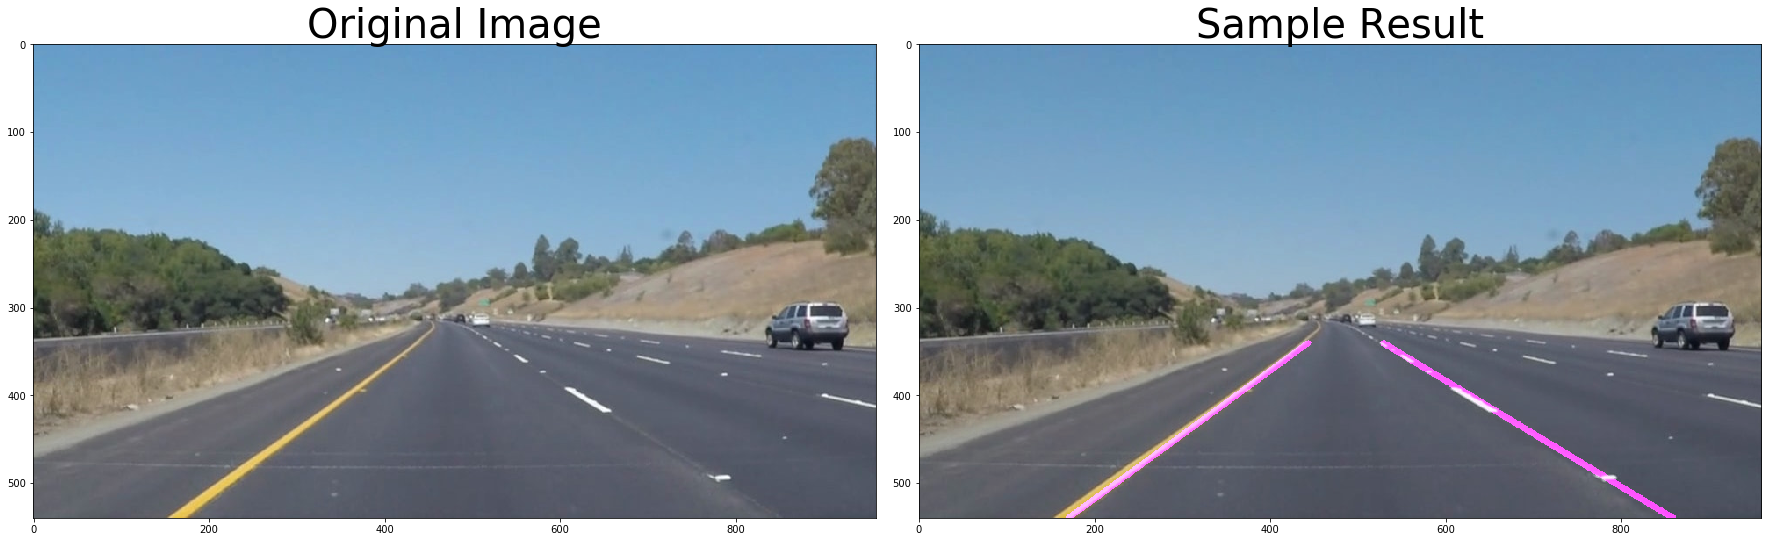

In [9]:
find_lanes('test_images/solidYellowCurve.jpg')

The lines seems to be reasonable on a sample image. Now I am ready to try on test images.

## Build a Lane Finding Pipeline for still images

To test on a collection of still images in a test directory and save the result, I am creating a helper function to save the resulting images.

In [10]:
def save_result(output_image, img):
    #create a directory for saving outputs if the directory does not exist
    if not os.path.isdir('test_images_output'):
        os.mkdir('test_images_output')
    #define the directory path to save outputs
    path_to_save = os.path.join('test_images_output/', img)
    #write a resulting image
    cv2.imwrite(path_to_save, output_image)

The following process ensures to go through all test images under the test directory and process lane detection steps.

In [11]:
def find_lanes_on_test(testdir):
    for img in os.listdir(testdir):
        #reading in an image with cv2 instead of mpimg
        image = cv2.imread(os.path.join(testdir, img))

        #need to change BGR to RGB because of cv2.imread()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        detected_edges = detect_edges(image)
        masked_edges = confine_roi(image, detected_edges)
        hough_lines = connect_edges(masked_edges)
        median_lanes = interpolate_lines(image, hough_lines)
        xys = get_xys(image.shape, median_lanes, margin=200)
        connected_lines = draw_lines(image, xys)
        #addWeighted src1, src1 weight, src2, src2 weight, bias
        output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
        
        #change colour BGR to RGB because of cv2
        output_image = cv2.cvtColor(output_lines, cv2.COLOR_BGR2RGB)
        
        #save the result from the image
        save_result(output_image, img)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        fig.tight_layout()

        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(output_lines)
        ax2.set_title('Sample Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Call the wrapper function above to test on all test images.

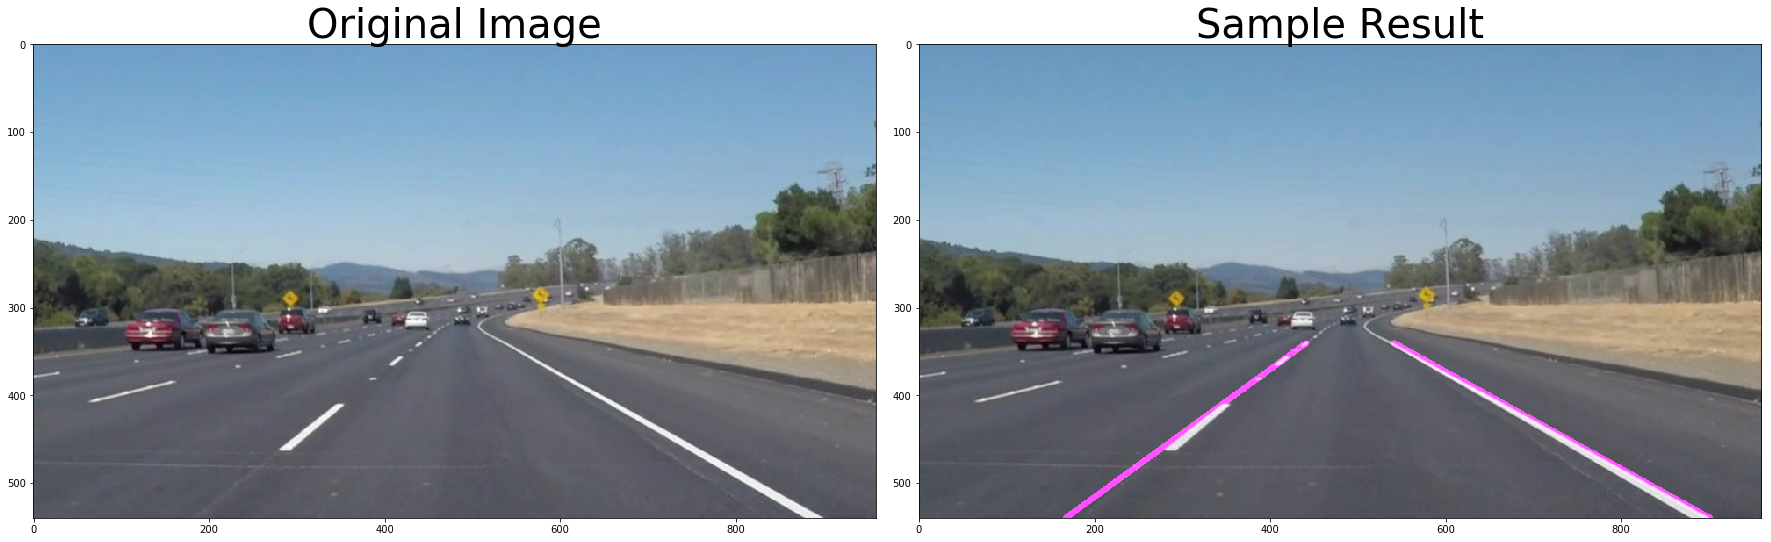

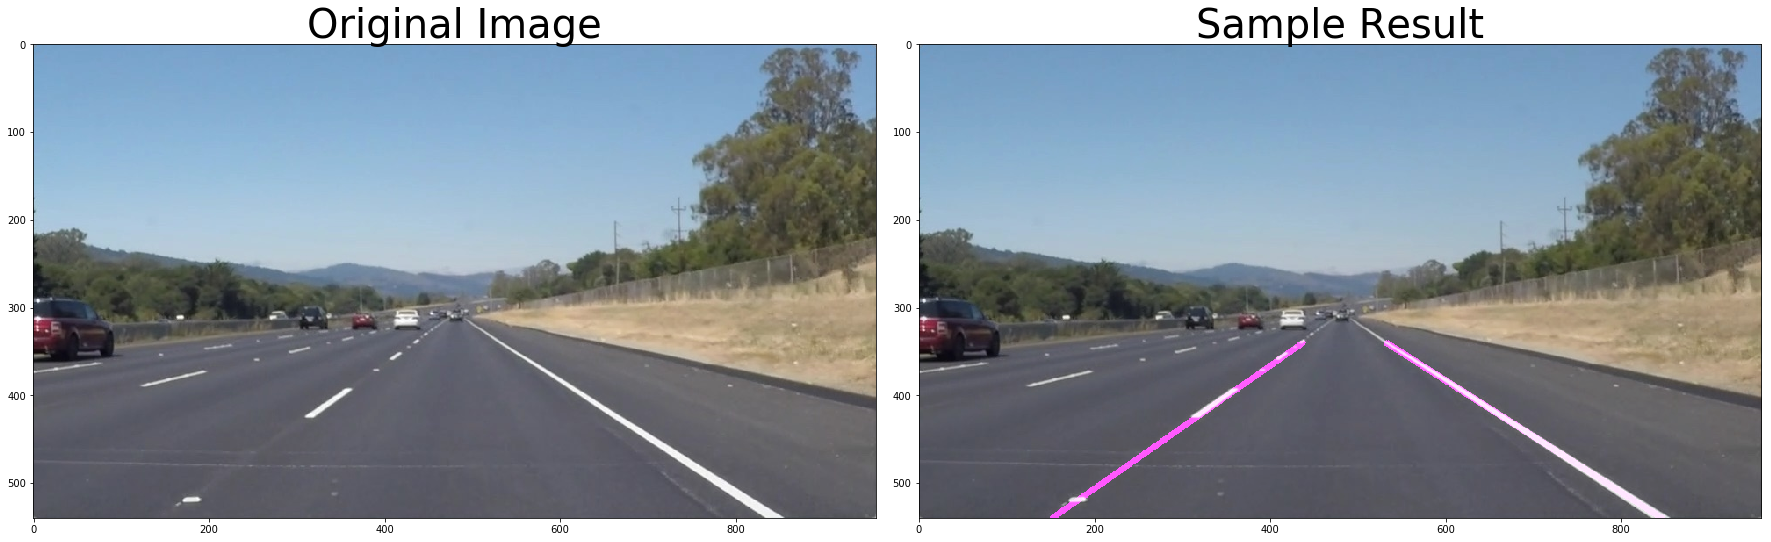

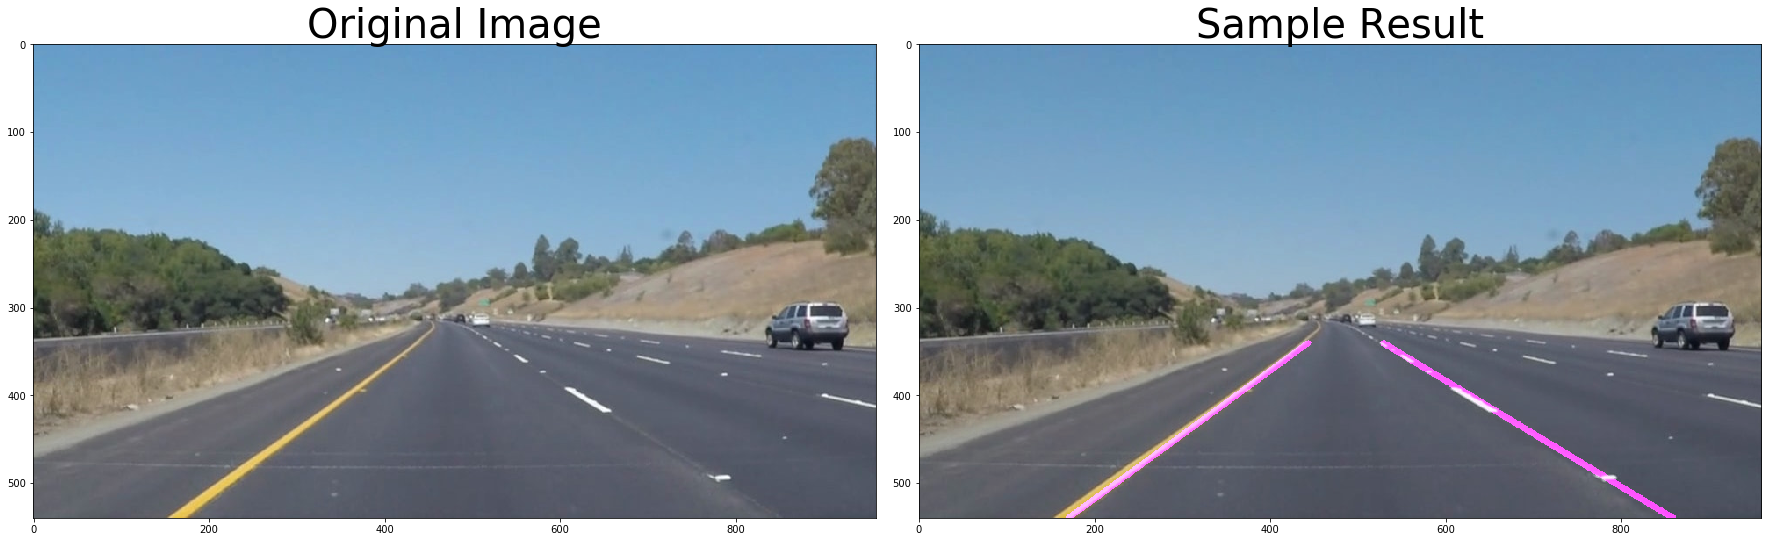

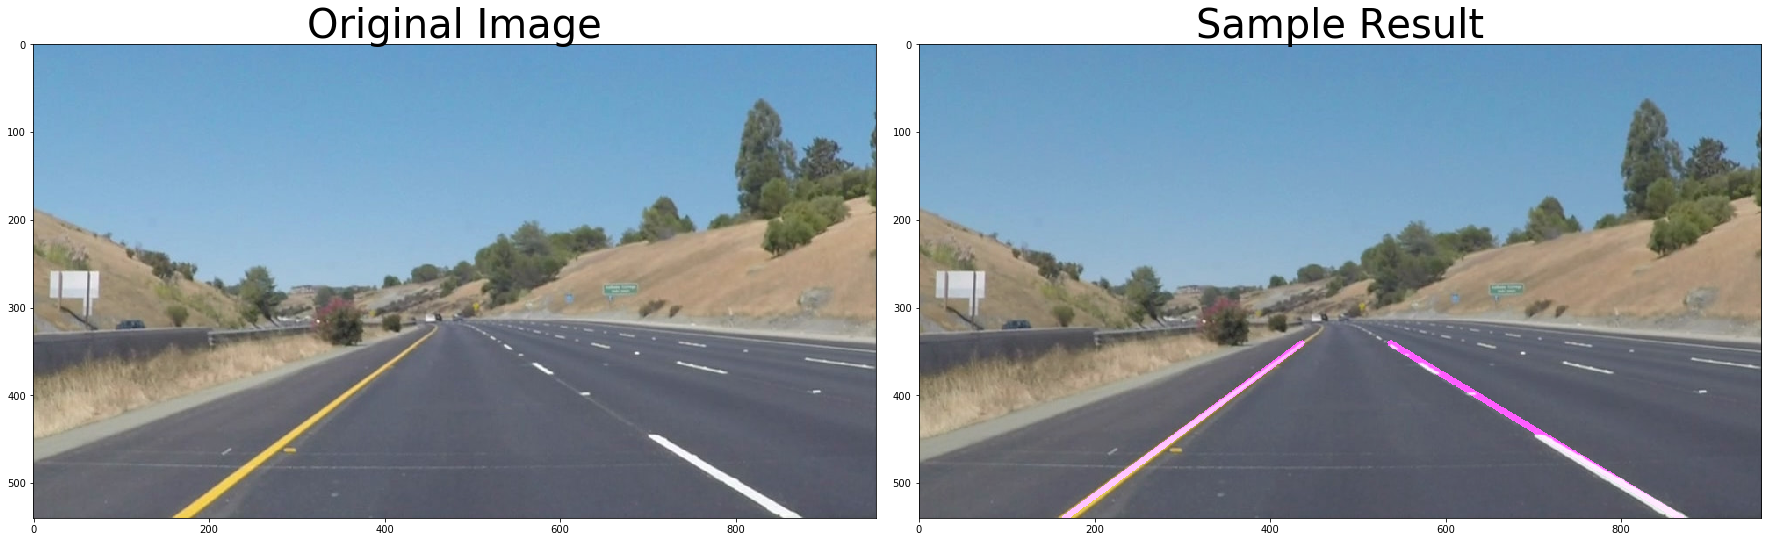

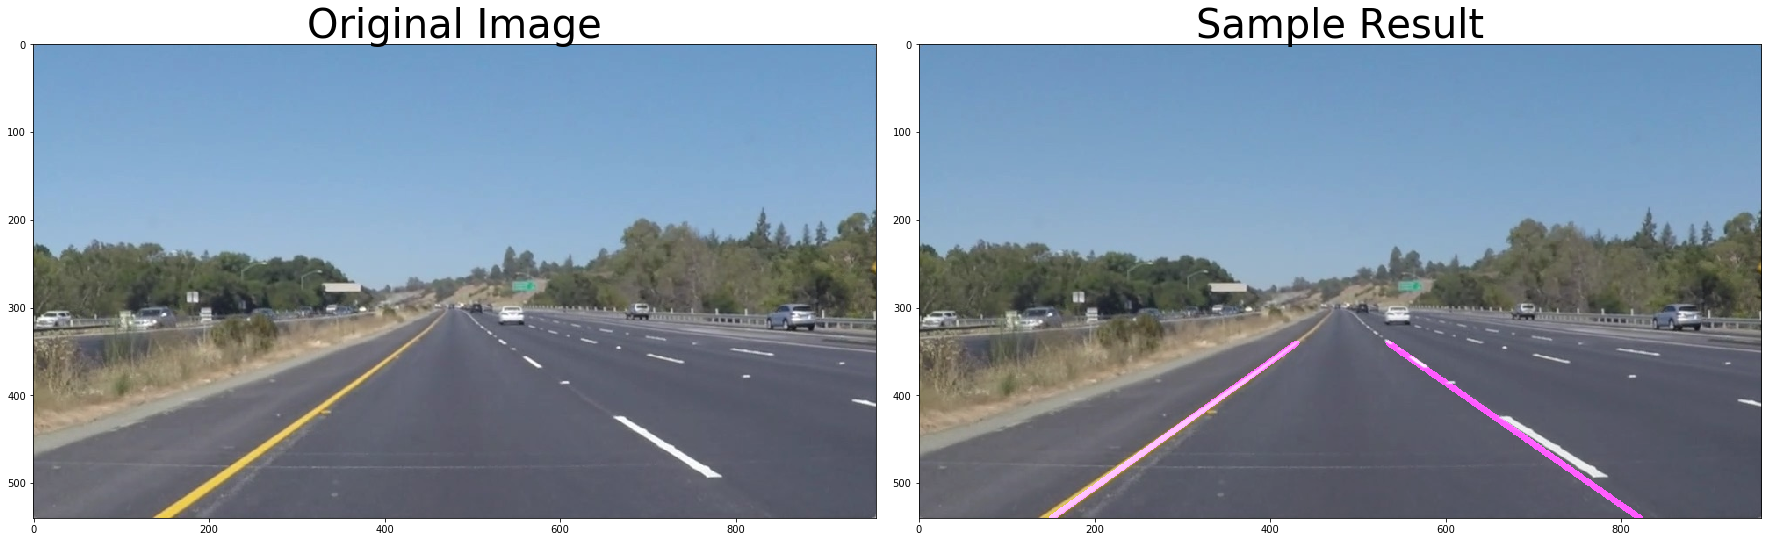

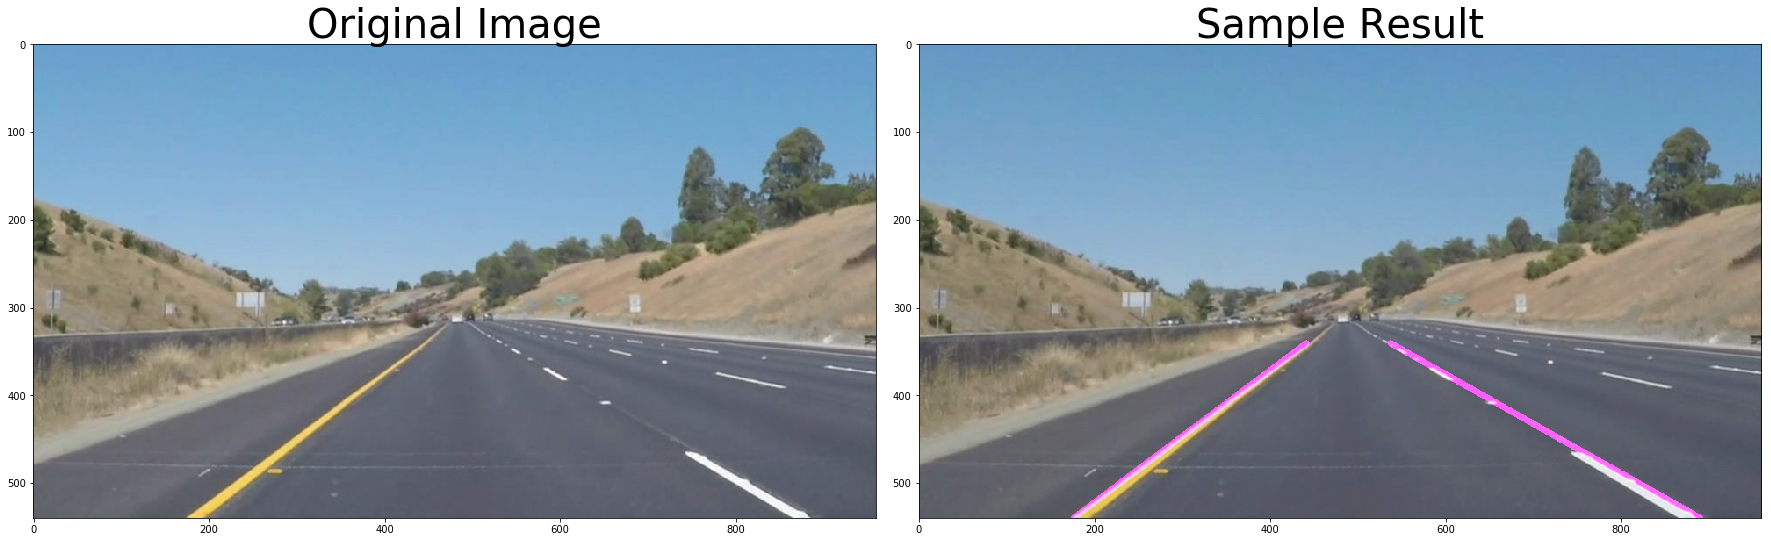

In [24]:
find_lanes_on_test("test_images/")

All lane detections on the test images look reasonable and now I would like to test on a sample of video streams.

## Build a Lane Finding Pipeline for video streams

The following code block is to fix errors arising from video processing later. The solution is discussed [here](https://discussions.udacity.com/t/error-ffmpeg-exe-file/231460).

In [12]:
#to fix the ffmpeg problem
!pip install imageio
import imageio

The pipeline for a lane detection for a still image is simplified below. The function process_image is then fed into fl_image() method in the VideoClip object to produce the resulting video streams. More documentation on the VideoClip object is found [here](https://zulko.github.io/moviepy/ref/VideoClip/VideoClip.html).

In [13]:
def process_image(image):
    #need to change BGR to RGB because of cv2.imread()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    detected_edges = detect_edges(image)
    masked_edges = confine_roi(image, detected_edges)
    hough_lines = connect_edges(masked_edges)
    median_lanes = interpolate_lines(image, hough_lines)
    xys = get_xys(image.shape, median_lanes, margin=200)
    connected_lines = draw_lines(image, xys)
    #addWeighted src1, src1 weight, src2, src2 weight, bias
    output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
    
    #change colour BGR to RGB because of cv2
    output_image = cv2.cvtColor(output_lines, cv2.COLOR_BGR2RGB)
    
    return output_image

The wrapper for testing two video streams are addressed below. I am not processing a challenge video at this point.

In [17]:
def find_lanes_on_test_videos(path_to_videos):
    for vdo in os.listdir(path_to_videos):
        if vdo!='challenge.mp4':
            #define a video stream to process and make it into many clips/images
            clip1 = VideoFileClip(path_to_videos+vdo)

            #replace each clip of a video stream with the processed result through the pipeline
            processed_clip = clip1.fl_image(process_image)

            #write each frame of output image into a video stream
            video_path_to_save = "test_videos_output/"+vdo
            %time processed_clip.write_videofile(video_path_to_save, audio=False)

In [18]:
find_lanes_on_test_videos('test_videos/')

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:06<00:00, 32.72it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.17 s, sys: 220 ms, total: 3.39 s
Wall time: 7.96 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 85%|████████▌ | 581/682 [00:19<00:03, 30.87it/s]


100%|█████████▉| 681/682 [00:22<00:00, 33.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.97 s, sys: 810 ms, total: 10.8 s
Wall time: 23.4 s


To visualise the videos, two resulting video streams are listed below.

In [19]:
solidWhiteRight = "test_videos_output/solidWhiteRight.mp4"
solidYellowLeft = "test_videos_output/solidYellowLeft.mp4"

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(solidWhiteRight))

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(solidYellowLeft))

The lane detection on two video streams look OK altough the curve towards the end of lanes could be detected better. This culvulture challenge is to be addressed in the second project! 